In [13]:
import os
#os.environ["MKL_THREADING_LAYER"] = "GNU"  

import matplotlib
#matplotlib.use('Agg')  # No GUI calls

import matplotlib.pyplot as plt

In [14]:
import torch
from torch import nn
import math
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

In [15]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class ConditionalTimeSeriesDataset(Dataset):
    def __init__(self, time_series_data, condition_data):
        """
        time_series_data: Tensor of shape (N, 252)
        condition_data: Tensor of shape (N, 3)
        """
        self.time_series_data = time_series_data
        self.condition_data = condition_data

    def __len__(self):
        return len(self.time_series_data)

    def __getitem__(self, idx):
        return self.time_series_data[idx], self.condition_data[idx]

In [16]:
class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_dim=252, condition_dim=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim + condition_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x, conditions):
        # Concatenate time series and condition
        x = torch.cat([x, conditions], dim=1)
        return self.model(x)

In [17]:
class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim=100, condition_dim=3, output_dim=252):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, z, conditions):
        # Concatenate noise and condition
        x = torch.cat([z, conditions], dim=1)
        return self.model(x)

In [18]:
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model_gan(real_samples, generated_samples):

    # convert list to numpy arrays
    predicted_values = generated_samples.cpu().numpy()  # [N, 255, 1]
    true_values = real_samples.cpu().numpy()            # [N, 255, 1]

    # flatten for metrics
    y_pred_flat = predicted_values.flatten()
    y_true_flat = true_values.flatten()
    
    # compute evaluation metrics
    mse = mean_squared_error(y_true_flat, y_pred_flat)
    mae = mean_absolute_error(y_true_flat, y_pred_flat)
    r2 = r2_score(y_true_flat, y_pred_flat)

    print(f"Validation MSE: {mse:.6f}")
    print(f"Validation MAE: {mae:.6f}")
    print(f"Validation R² Score: {r2:.6f}")

    return mse, mae, r2

# Data Prep

In [19]:
batch_size=32
torch.manual_seed(1)

In [20]:
data_output = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/epsteinCV_outputs_active.csv", header=None)

scaler = MinMaxScaler()
data_output_scaled = scaler.fit_transform(data_output)
data_output = pd.DataFrame(data_output_scaled)

# --- Load the conditioning input parameters ---
data_input = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/epsteinCV_inputs.csv", sep=" ", header=None)

# --- Combine input + output ---
data = pd.concat([data_input, data_output], axis=1)

# --- Sample to 1280 examples if needed ---
data = data.sample(n=20000, random_state=1)

# --- Split into training and validation sets ---
train_data_pd, valid_data = train_test_split(data, test_size=0.2, random_state=42)

# Save validation data for baseline

valid_data.iloc[:, :3].to_csv("valid_inputs_epstein.csv", index=False)
valid_data.iloc[:, 3:].to_csv("valid_outputs_epstein.csv", index=False)

# --- Extract tensors for training ---
train_inputs = torch.tensor(train_data_pd.iloc[:, :3].values, dtype=torch.float32)
train_outputs = torch.tensor(train_data_pd.iloc[:, 3:].values, dtype=torch.float32)

valid_inputs = torch.tensor(valid_data.iloc[:, :3].values, dtype=torch.float32)
valid_outputs = torch.tensor(valid_data.iloc[:, 3:].values, dtype=torch.float32)

In [21]:
train_data_length = train_inputs.shape[0]
train_data = torch.from_numpy(train_data_pd.values).float().to('cpu')
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]
train_data.shape

torch.Size([16000, 255])

In [22]:
train_dataset = ConditionalTimeSeriesDataset(train_outputs, train_inputs)
valid_dataset = ConditionalTimeSeriesDataset(valid_outputs, valid_inputs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# Training

In [72]:
discriminator = ConditionalDiscriminator()
generator = ConditionalGenerator()

In [74]:
lr = 0.001
num_epochs = 300
loss_function = nn.BCELoss()

In [75]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [37]:
losses_discriminator = []
losses_generator = []
steps = []

for epoch in range(num_epochs):
    for n, (real_samples, condition_vectors) in enumerate(train_loader):
        # real_samples: (batch_size, 252)
        # condition_vectors: (batch_size, 3)

        real_samples_labels = torch.ones((batch_size, 1))
        generated_samples_labels = torch.zeros((batch_size, 1))

        # Sample latent space
        latent_dim = 100
        latent_space_samples = torch.randn((batch_size, latent_dim))  # Latent space dimension

        # Ensure condition_vectors has the same batch size as latent_space_samples
        condition_vectors = condition_vectors.expand(batch_size, -1)  # Repeat condition vectors to match batch size

        # === Generator step ===
        # Pass latent_space_samples and condition_vectors separately to the generator
        generated_samples = generator(latent_space_samples, condition_vectors)

        # === Prepare discriminator input ===
        all_samples = torch.cat((real_samples, generated_samples.detach()), dim=0)
        all_conditions = torch.cat((condition_vectors, condition_vectors), dim=0)  # Duplicate for both real and generated
        all_labels = torch.cat((real_samples_labels, generated_samples_labels), dim=0)

        # === Train discriminator ===
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples, all_conditions)
        loss_discriminator = loss_function(output_discriminator, all_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # === Train generator ===
        generator.zero_grad()
        # Generate again to avoid using detached samples
        generated_samples = generator(latent_space_samples, condition_vectors)
        output_discriminator_generated = discriminator(generated_samples, condition_vectors)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()
        
        # === Logging (every 100 iterations per epoch) ===
        if n % 100 == 0 and epoch % 25 == 0:  # Adjust this number to control how often you log
            losses_discriminator.append(loss_discriminator.item())
            losses_generator.append(loss_generator.item())
            steps.append(epoch * len(train_loader) + n)
            print(f"Epoch: {epoch} Step: {n} Loss D.: {loss_discriminator.item()}")
            print(f"Epoch: {epoch} Step: {n} Loss G.: {loss_generator.item()}")


Epoch: 0 Step: 0 Loss D.: 0.6895778179168701
Epoch: 0 Step: 0 Loss G.: 0.7361276745796204
Epoch: 0 Step: 100 Loss D.: 0.24503621459007263
Epoch: 0 Step: 100 Loss G.: 4.208373069763184
Epoch: 0 Step: 200 Loss D.: 0.7905083894729614
Epoch: 0 Step: 200 Loss G.: 1.1930031776428223
Epoch: 0 Step: 300 Loss D.: 0.08420190960168839
Epoch: 0 Step: 300 Loss G.: 4.240823745727539
Epoch: 0 Step: 400 Loss D.: 0.12783898413181305
Epoch: 0 Step: 400 Loss G.: 7.793726444244385
Epoch: 25 Step: 0 Loss D.: 0.028819376602768898
Epoch: 25 Step: 0 Loss G.: 8.701231956481934
Epoch: 25 Step: 100 Loss D.: 0.11279679834842682
Epoch: 25 Step: 100 Loss G.: 5.679566383361816
Epoch: 25 Step: 200 Loss D.: 0.17639392614364624
Epoch: 25 Step: 200 Loss G.: 5.095211982727051
Epoch: 25 Step: 300 Loss D.: 0.0748375728726387
Epoch: 25 Step: 300 Loss G.: 7.170220375061035
Epoch: 25 Step: 400 Loss D.: 0.06456062197685242
Epoch: 25 Step: 400 Loss G.: 4.839427947998047
Epoch: 50 Step: 0 Loss D.: 0.3298914432525635
Epoch: 50 St

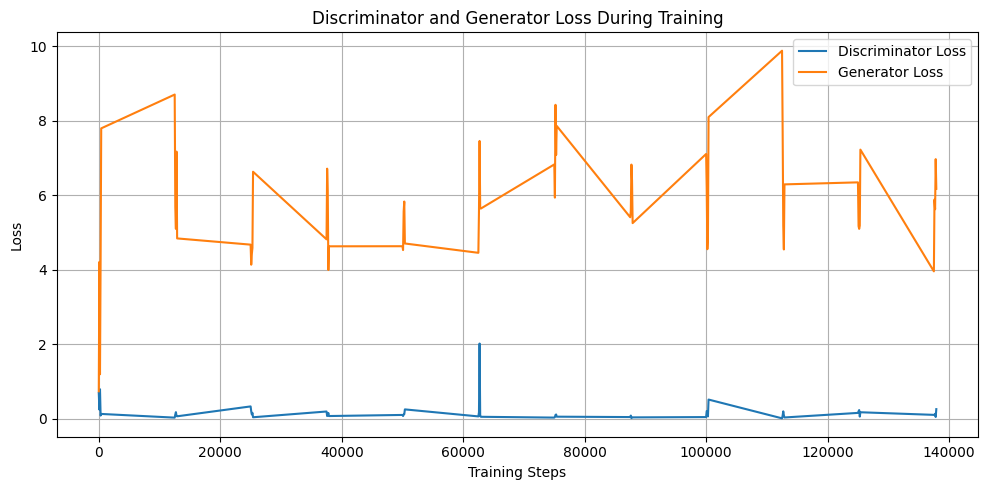

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(steps, losses_discriminator, label='Discriminator Loss')
plt.plot(steps, losses_generator, label='Generator Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Loss During Training')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
torch.save(generator.state_dict(), "generator_gan_ecv_base.pth")
torch.save(discriminator.state_dict(), "discriminator_gan_ecv_base.pth")

# Inference

In [23]:
n_samples = len(valid_dataset)
indices = np.arange(0,n_samples)

real_samples = []
real_conditions = []

for idx in indices:
    real_ts, condition = valid_dataset[idx]
    real_samples.append(real_ts)
    real_conditions.append(condition)

real_samples = torch.stack(real_samples)           # (n_samples, 252)
real_conditions = torch.stack(real_conditions)     # (n_samples, 3)

generator = ConditionalGenerator()

# Load saved weights
generator.load_state_dict(torch.load("generator_gan_ecv_base.pth"))

# Set to evaluation mode
generator.eval()

with torch.no_grad():
    latent_dim = 100  # or whatever your latent size is
    z = torch.randn(n_samples, latent_dim)
    generated_samples = generator(z, real_conditions)  # (n_samples, 252)

In [29]:
evaluate_model_gan(real_samples, generated_samples)

Validation MSE: 0.029105
Validation MAE: 0.085935
Validation R² Score: 0.436856


(0.029104700312018394, 0.08593504875898361, 0.4368557929992676)

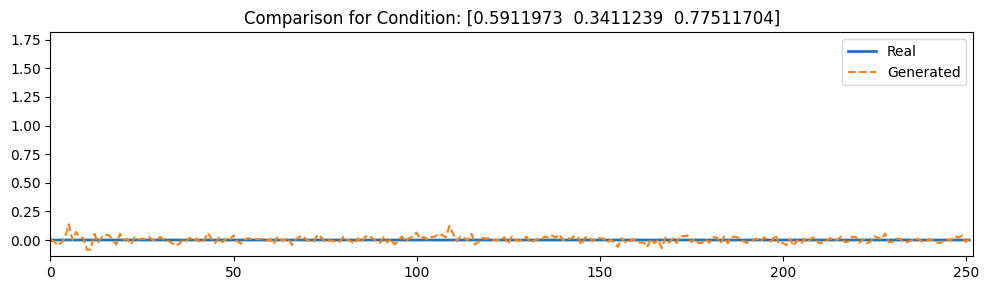

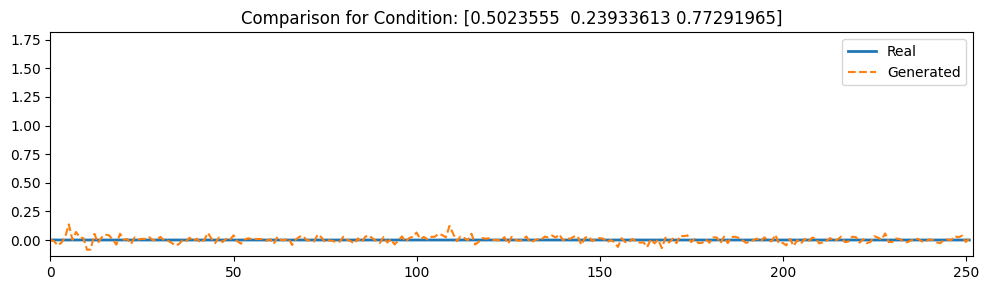

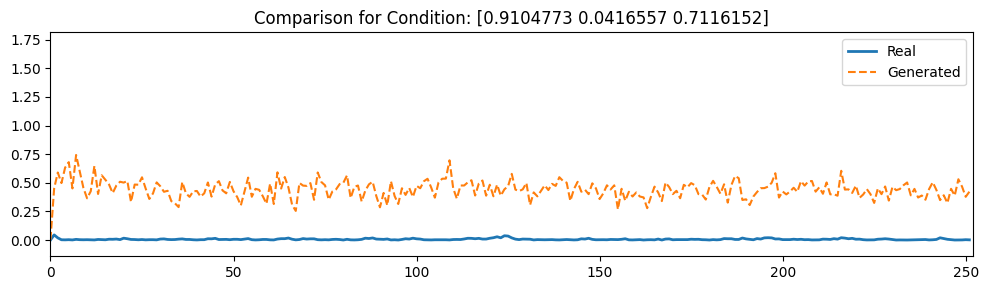

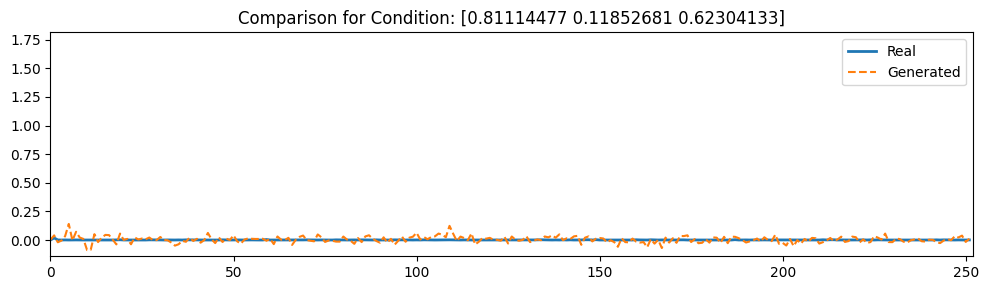

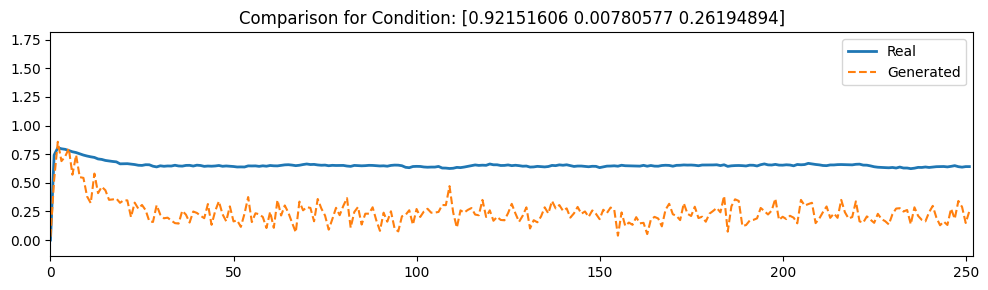

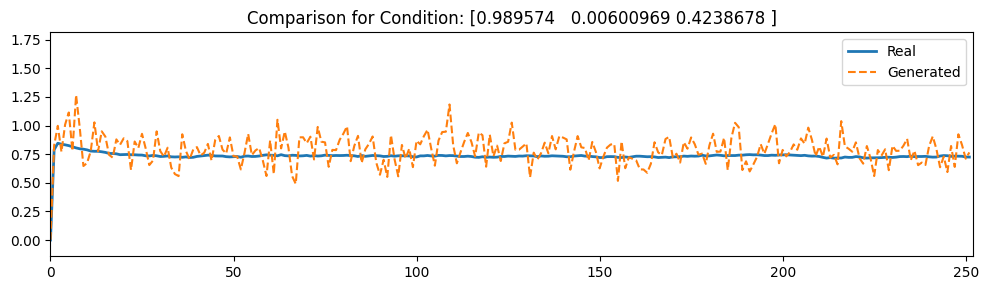

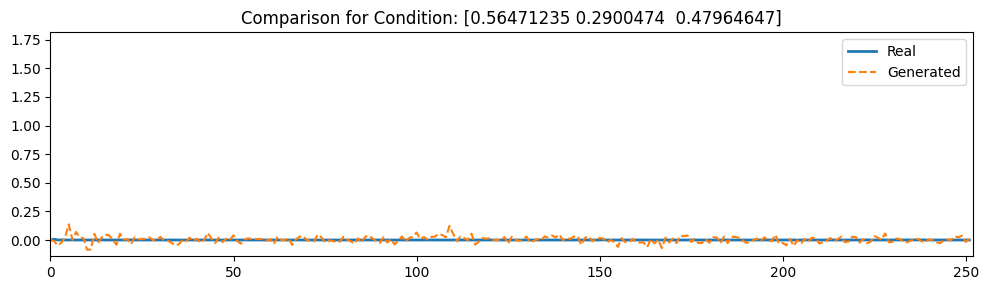

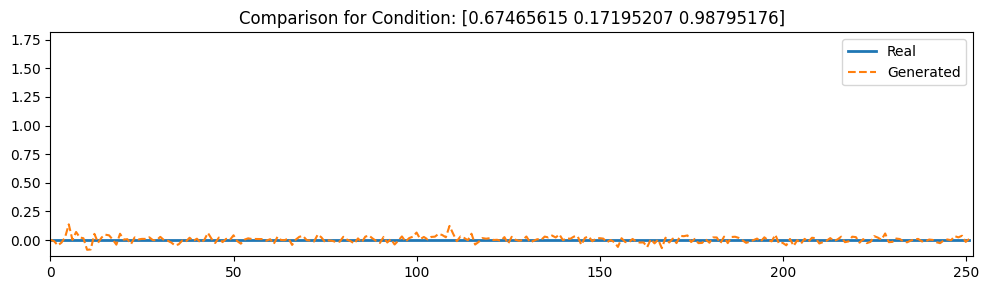

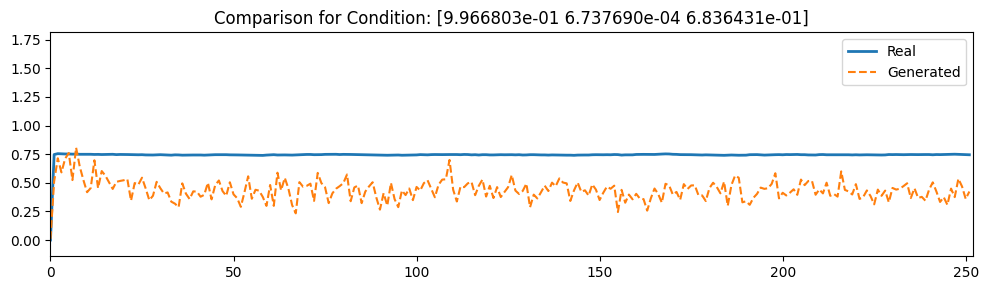

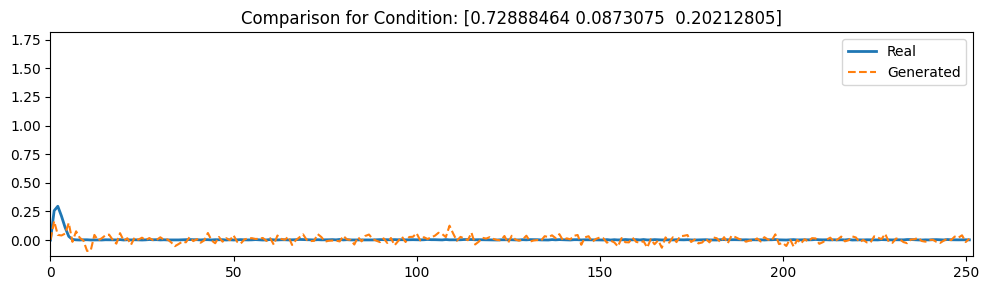

In [115]:
# Calculate the global min and max for both real and generated samples
min_val = min(real_samples.min(), generated_samples.min())
max_val = max(real_samples.max(), generated_samples.max())

# Assuming real_samples, generated_samples, and real_conditions are already in the correct shape

for i in range(10):
    plt.figure(figsize=(10, 3))
    plt.plot(real_samples[i].cpu().numpy(), label="Real", linewidth=2)
    plt.plot(generated_samples[i].cpu().numpy(), label="Generated", linestyle="--")
    
    # Set the axis limits based on global min and max
    plt.xlim(0, len(real_samples[i]))  # Standardize x-axis (if you know your x range)
    plt.ylim(min_val, max_val)  # Standardize y-axis

    plt.title(f"Comparison for Condition: {real_conditions[i].cpu().numpy()}")
    plt.legend()
    plt.tight_layout()
    plt.show()

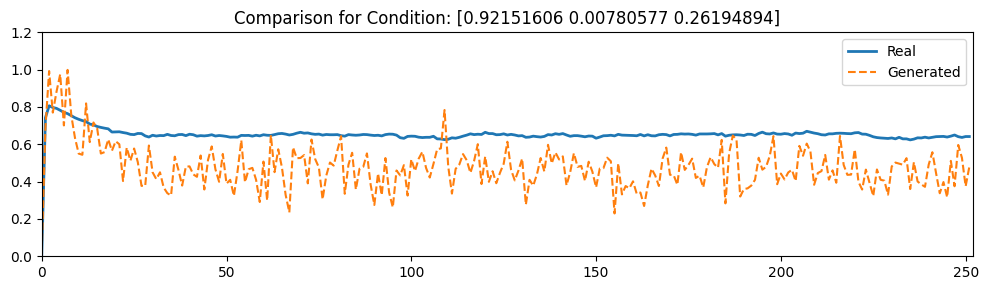

In [31]:
# Calculate the global min and max for both real and generated samples
min_val = 0
max_val = 1.2

# Assuming real_samples, generated_samples, and real_conditions are already in the correct shape

i=4
plt.figure(figsize=(10, 3))
plt.plot(real_samples[i].cpu().numpy(), label="Real", linewidth=2)
plt.plot(generated_samples[i].cpu().numpy(), label="Generated", linestyle="--")
    
# Set the axis limits based on global min and max
plt.xlim(0, len(real_samples[i]))  # Standardize x-axis (if you know your x range)
plt.ylim(min_val, max_val)  # Standardize y-axis

plt.title(f"Comparison for Condition: {real_conditions[i].cpu().numpy()}")
plt.legend()
plt.tight_layout()
plt.show()